In [2]:
import os
os.environ['autocnet_config'] = '/home/jlaura/autocnet_projects/demo.yml'
%pylab inline
from autocnet_server.graph.graph import NetworkCandidateGraph

Populating the interactive namespace from numpy and matplotlib


In [30]:
# Create the candidate graph
ncg = NetworkCandidateGraph.from_database()

## Feature Extraction
The primary method to work with the candidate graph is very functional in style. After defining the [extractor parameters](http://www.vlfeat.org/overview/sift.html#tut.sift.param) that we find to work well with CTX, the extraction function is [mapped](https://docs.python.org/3/howto/functional.html#built-in-functions) over all of the nodes. That is, the algorithm `extract_features_with_tiling` is applied (hence our use of `apply`!) to every node in the graph (or sub-graph should we select a sub-graph). 

Using a small subset of data, extraction times can vary between a few minutes to more than fifteen minutes. This process occurs only once though.

The cell below has been converted to [Raw NBConvert](https://ipython.org/ipython-doc/3/notebook/nbformat.html#raw-nbconvert-cells) so that it can be executed without actually running anything. This is because, as described above, it is not necessary to run extraction more than once.

## Spatializing the Keypoints
Keypoints are extracted in image space (x/y or sample/line coordinates). While it is possible to match images using just pixel coordinate and descriptor information, it is more powerful to also utilize available spatial information. Since a CSM sensor model exists for CTX data, it is possible to project the line/sample coordinates into some other reference frame. AutoCNet stores the keypoints in both sample/line and body-fixed (xyz) reference frames. In order to compute this, the `project_keypoints` method is applied to all of the nodes.  This method computes the ground point correspondending to each pixel center and updates the associated HDF5 file.

In [ ]:
ncg.apply('project_keypoints', on='node')

## Ring Matching
Ring matching functions by using a priori information about where correspondences should exist and geometric information about groups of correspondences in order to find a solution in which correspondences have a consistent geometric relationship. In other words, if the points in one image are systematically offset by 10 pixels in the x direction and 5 pixels in the y direction, this matcher will identify both the correspondences in the distance band in which the correspondences fall.  The ring matcher requires that (1) features be extracted and (2) features be projected through a sensor model into some common reference frame. For AutoCNet that reference frame can be body fixed (the default) or some map projected space. 

The ring matcher functions by taking a starting point, a ring radius, and a maximum search radius. Concentric rings, centered on the starting point are identified with a total width of ring radius. For a ring radius of 30 and a max_radius of 300, ten concentric rings will be created. The interest feature in one image will then attempt to match to 10 candidate correspondences, one in each ring. This process is repeated until some number of target_points have been identified in one or more bins. Once this occurs, the algorithm shifts to assessing geometric distances between points within a given ring. For this to occur, the distance between points in one image (the source) is compared to the distance between the correponding points in the other image (the destination). If the ratio of that distance is less than or equal to the tolerance_val, those points are deemed valid for that iteration.  This process is then repeated for all candidate points. Should the solution have more than target points, the algorithm terminates.

To parametrize the matcher it is necessary to define:

* ring_radius : the number of units (meters in body-fixed) that are contained within each concentric ring
* max_radius : the maximum radius in units. the max_radius / ring_radius defines the number of concentric rings to be searched
* target_points : the total number of points required
* tolerance_val : if 1-tolerance_val <= d(a)/d(b) <= 1+tolerance_val the match is deemed valid

## Applying to a graph
One way to test the algorithm is to apply it to the entire graph. Here, the 'ring_match' algorithm is applied to all of the edges in the graph. The matches are then written to the database.

If one wanted to work with a subgraph (subset) of the graph, it is possible to simply:

```python
sub = ncg.subgraph(nodes=['list_of_nodes'])
sub.apply('ring_match', on='edge', ring_radius=30, max_radius=300, target_points=25, tolerance_val=0.1)
```

In [3]:
ncg.apply('ring_match', on='edge', ring_radius=30, max_radius=300, target_points=25, tolerance_val=0.1)
# The printed integer is the number of nodes/edges that the algorithm is applied to

## Traditional Matching
In a more traditional approach, features are extracted and feature descriptors are compared to find matches. To compare descriptors a [kd-tree](https://en.wikipedia.org/wiki/K-d_tree) or approximate kd-tree are used. These data structures work to partition the 128-dimension space (most descriptors are 128 element encoding) for more efficient searches. While a brute-force comparison would need to compare a descriptor in one image to all of the descriptors in another image, a kd-tree is searchable (in general) much more efficiently.  

For small images, a traditional matching approach can work quite well. Matching using this approach is a multi-step process:

* apply the descriptor based matcher
* apply a symmetry check to see if correspondences identified in AB are also identified in BA
* apply a ratio check to ensure that the 'likeness' of the top match is distinct from the second best match

As above, it is possible to apply these methods to a graph or subgraph:

```python
ncg.apply('match', on='edge')
ncg.apply('symmetry_check', on='edge')
ncg.apply('ratio_check', on='edge', ratio=0.9)
```

## Using the sensor model

Frequently, the a priori pointing of the images is pretty good. It is possible to use a 'close' initial solution to then iterate to a better solution. Matching using a sensor model can be done with or without extracting features.

Here we take a single node and demonstrate how to project from image space, to body fixed space, and to Lat/Lon. All of these are different [reference frames](https://en.wikipedia.org/wiki/Frame_of_reference) and here we illustrate how to move between them.

#### Image Space to Body Fixed

In [5]:
from csmapi import csmapi # This is the library that exposes sensor models

# Projecting a pixel location into body fixed
node = ncg.node[11]['data'] # We want the data, not the node object
camera = node.camera

ic = csmapi.ImageCoord(1,1) # Pixel 1,1 (the upper left)
ground = camera.imageToGround(ic, 0) # The third argument is the elevation. Zero is fine for now
print(ground.x, ground.y, ground.z) # This is in body fixed

-3079654.6596794967 1350411.094732567 472830.0949666512


#### Body Fixed to Lat/Lon

In [9]:
import pyproj  # The python bindings to the proj4 library: https://jswhit.github.io/pyproj/

# This is the projection for body centered body fixed (Mars)
bcbf = pyproj.Proj(proj='geocent',
                   a=3396190,
                   b=3376200)
# This is the projection for latitude/longitude space (Mars)
lla = pyproj.Proj(proj='longlat',
                  a=3396190,
                  b=3376200)
# This is the transformation to convert from bcbf to lat/lon/alt
lon, lat, alt = pyproj.transform(bcbf, lla, ground.x, ground.y, ground.z)
print(lon, lat, alt)

156.3228217111069 8.097660662702573 -4.656612873077393e-10


#### Inverse: Lat/Lon to Pixel Space
The above two code cells illustrate how to go from pixel space, to body fixed space, to lat/lon. Using this approach, it is possible to reverse the transformation, starting with lat/lon and then pushing back into the pixel.

Below, this is demonstrated.

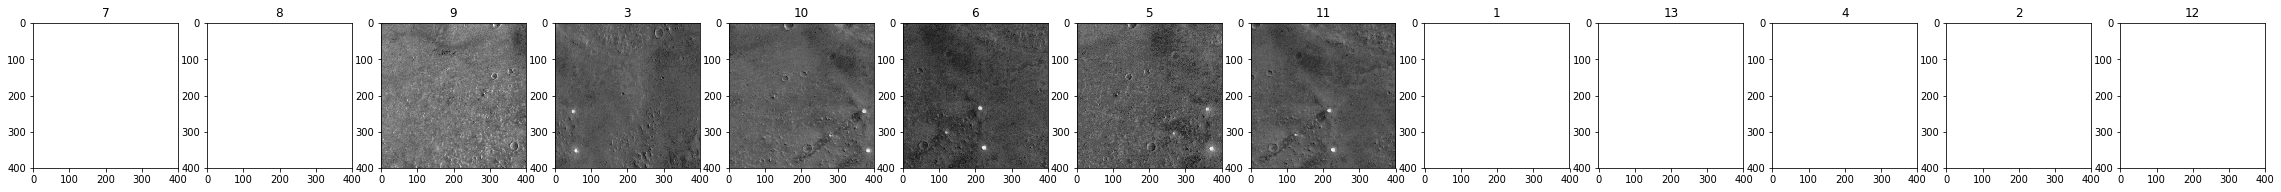

In [23]:
from autocnet.matcher.subpixel import clip_roi  # A helper from autocnet that clips a region of interest

figsize(40,10)  # So we have a large enough figure to see what is going on
lon = 156.45
lat = 8.75
bfx, bfy, bfz = pyproj.transform(lla, ecef, lon, lat, 0)  # lla and ecef were defined above. the first float is the longitude, the second is latitude, and the final one is altitude
size = 200  # How large of an image do we want to see?

# Create a matplotlib figure with a number of subplots equal to the number of nodes.
nfigs = len(ncg)
fig, axes = plt.subplots(1, nfigs)

for j, (i, n) in enumerate(ncg.nodes(data='data')):
    
    # Set the title
    axes[j].set_title("{}".format(i))
    
    # Get the node's camera
    camera = n.camera
    
    # Get the pixel coordinate
    coord = csmapi.EcefCoord(bfx, bfy, bfz)
    try:
        image_coord = camera.groundToImage(coord)
        sx = image_coord.samp
        sy = image_coord.line
        a, _, _ = clip_roi(n._geodata, sx, sy, size_x=size, size_y=size)
        axes[j].imshow(a, cmap='Greys')
    except:
        axes[j].imshow(np.zeros((400,400)), cmap='Greys') 

show()

#### Where are the lat/lon numbers coming from?
AutoCNet has a helper method to visualize the image footprints. Here the footprints are plotted with 50% opacity and a black border.

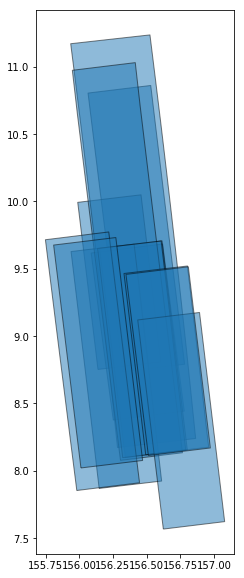

In [24]:
fp = ncg.footprints()
fp.plot(edgecolor='black', alpha=0.5)

## Using the sensor model with a subpixel matcher

For this I wrote a little helper function (at the bottom of the notebook. Cruise down to the last cell and run it to get the function into the namespace. The example above illustrates how the a priori pointing is not good enough. This example takes the a priori pointing and then applies an iterative subpixel matcher. Note that this still starts with the lat/lon.

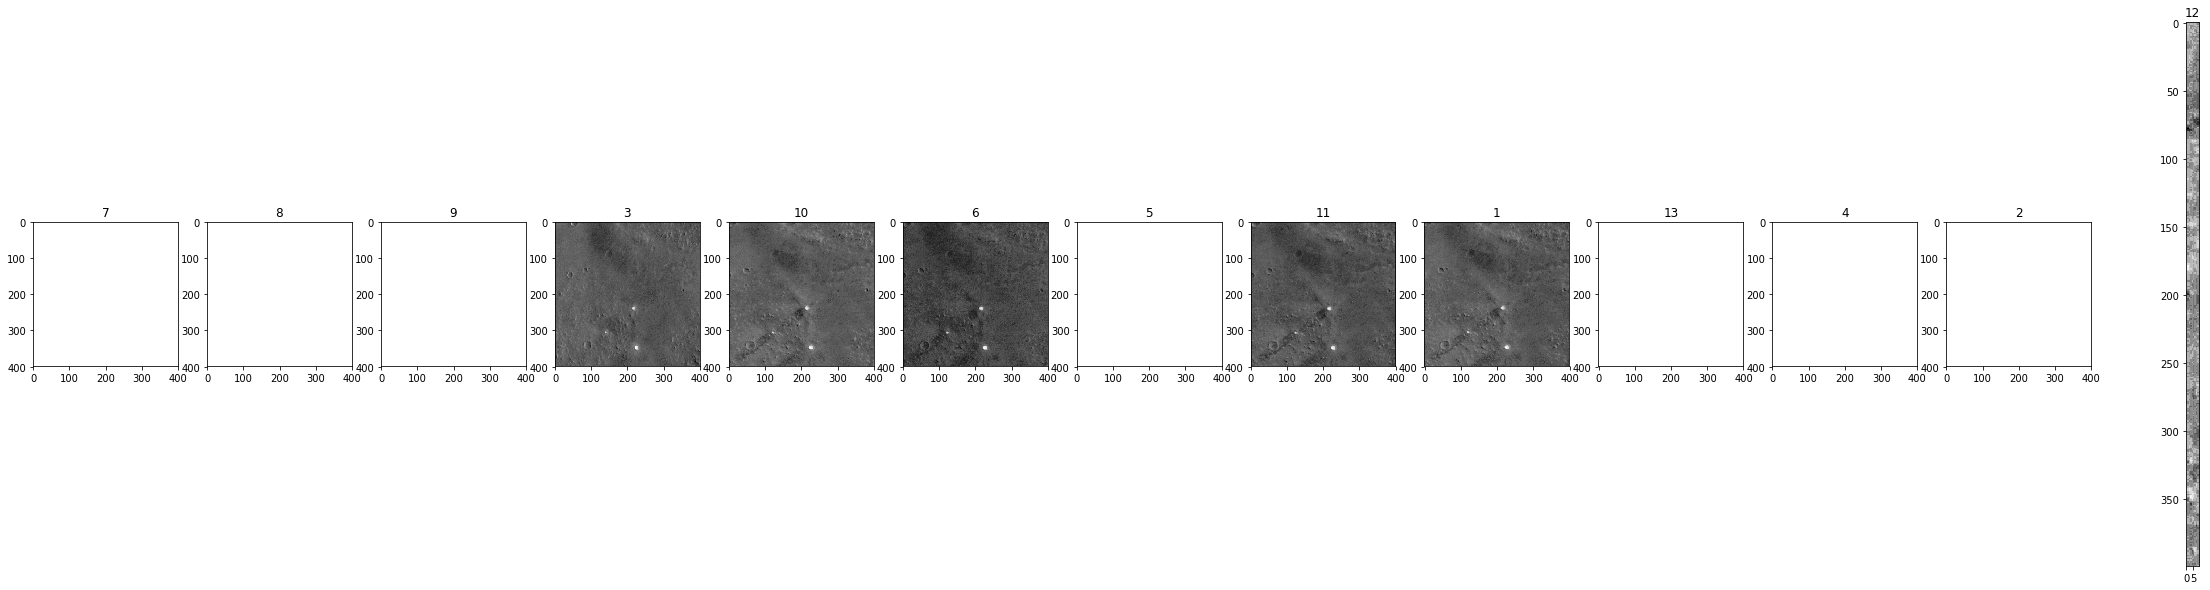

In [27]:
# From above
lon = 156.45
lat = 8.75
bfx, bfy, bfz = pyproj.transform(lla, ecef, lon, lat, 0)  
size = 200  

# Create a matplotlib figure with a number of subplots equal to the number of nodes.
nfigs = len(ncg)
fig, axes = plt.subplots(1, nfigs)

# Define one image as the 'reference'. All other images are matched to this image
node = ncg.node[11]['data']
cam11 = node.camera
gnd = csmapi.EcefCoord(bfx, bfy, bfz)  # Here the lat/lon is projected into node 11 pixel space
ic = c11.groundToImage(gnd)
sx = ic.samp
sy = ic.line
s_img = node.geodata  # Get the source image (the array)

# Now iterate over all of the nodes
for j, (i, n) in enumerate(ncg.nodes(data='data')):
    axes[j].set_title("{}".format(i))
    if i == 11:
        # If this is the source node, just visualize it
        a, _, _ = clip_roi(s_img, sx, sy, size_x=size, size_y=size)
        axes[j].imshow(a, cmap='Greys')
        continue
    
    # Try to project the lat/lon into a different node (not 11)
    cam = n.camera
    try:
        ic = cam.groundToImage(gnd)
    except:
        # Not in the image, so continue
        axes[j].imshow(np.zeros((400,400)), cmap='Greys') 
        continue
    
    dx = ic.samp
    dy = ic.line
    d_img = n.geodata

    # Attempt to subpixel register
    try:
        res = refine_subpixel(sx, sy, dx, dy, s_img, d_img, 251)
    except:
        res = None 
    # If registered, clip the image to show, notice the example the one match right at the edge of the image
    if res:
        shift_x = res[0] - dx
        shift_y = res[1] - dy
        a, _, _ = clip_roi(d_img, res[0], res[1], size_x=size, size_y=size)
        axes[j].imshow(a, cmap='Greys')
    else:
        axes[j].imshow(np.zeros((400,400)), cmap='Greys')  
show()

## Sensor + Subpixel Phase + Subpixel Template

This example adds one more step.  The `res` variable above contains the x-shift, y-shift, and then 2 correlation metrics.  These are generally very close to zero. Below a template based matcher with a standard correlation is added.

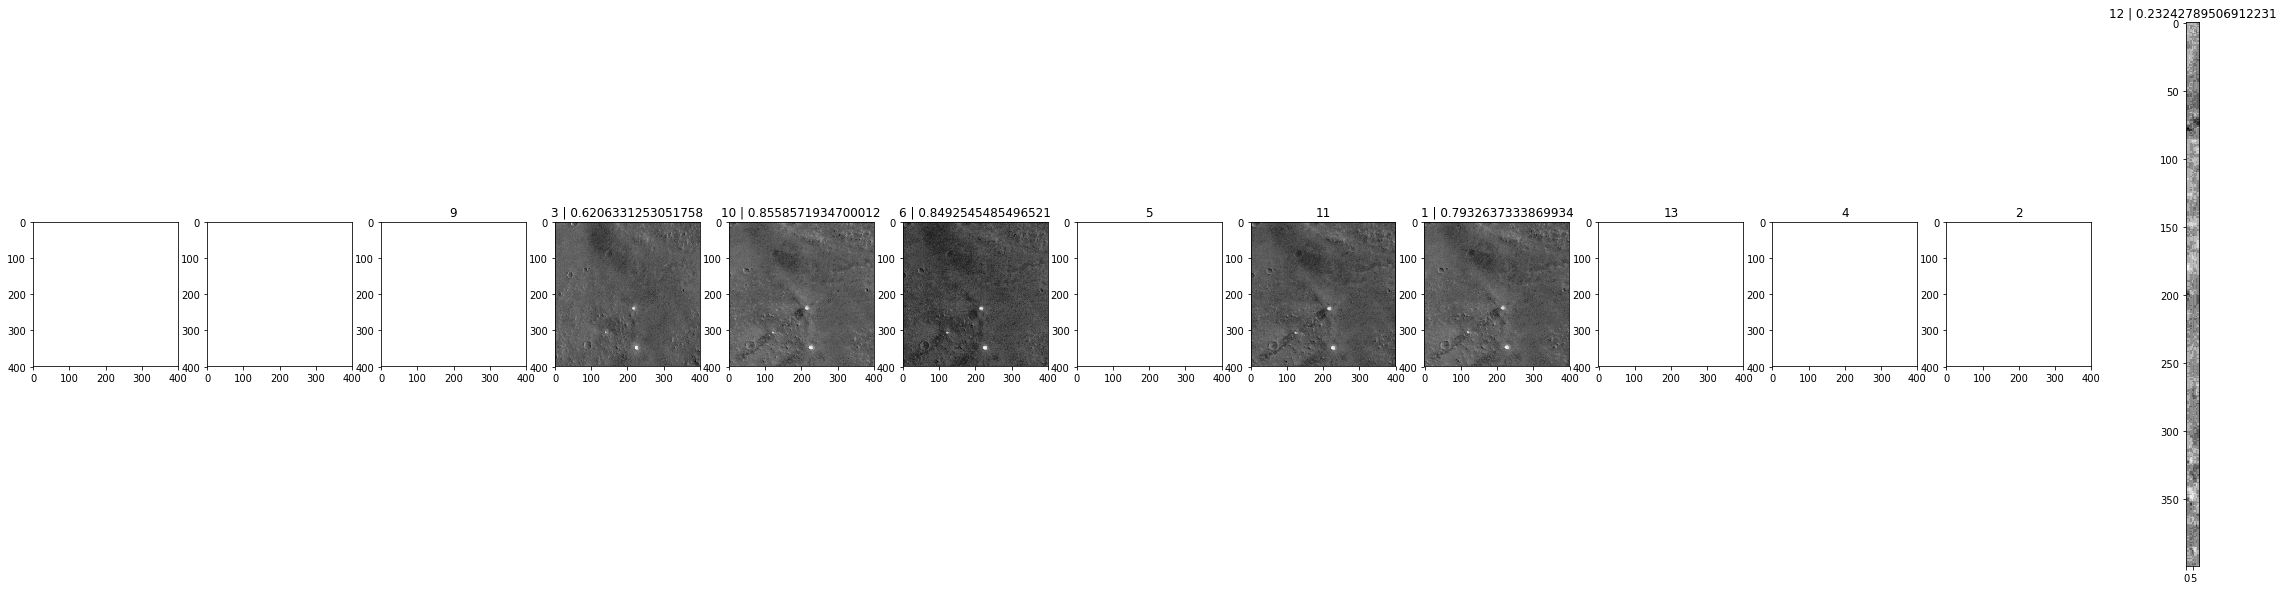

In [29]:
# From above
lon = 156.45
lat = 8.75
bfx, bfy, bfz = pyproj.transform(lla, ecef, lon, lat, 0)  
size = 200  

# Create a matplotlib figure with a number of subplots equal to the number of nodes.
nfigs = len(ncg)
fig, axes = plt.subplots(1, nfigs)

# Define one image as the 'reference'. All other images are matched to this image
node = ncg.node[11]['data']
cam11 = node.camera
gnd = csmapi.EcefCoord(bfx, bfy, bfz)  # Here the lat/lon is projected into node 11 pixel space
ic = c11.groundToImage(gnd)
sx = ic.samp
sy = ic.line
s_img = node.geodata  # Get the source image (the array)

# Now iterate over all of the nodes
for j, (i, n) in enumerate(ncg.nodes(data='data')):
    
    if i == 11:
        # If this is the source node, just visualize it
        a, _, _ = clip_roi(s_img, sx, sy, size_x=size, size_y=size)
        axes[j].imshow(a, cmap='Greys')
        axes[j].set_title("{}".format(i))
        continue
    
    # Try to project the lat/lon into a different node (not 11)
    cam = n.camera
    try:
        ic = cam.groundToImage(gnd)
    except:
        # Not in the image, so continue
        axes[j].imshow(np.zeros((400,400)), cmap='Greys') 
        continue
    
    dx = ic.samp
    dy = ic.line
    d_img = n.geodata

    # Attempt to subpixel register
    try:
        res = refine_subpixel(sx, sy, dx, dy, s_img, d_img, 251)
    except:
        res = None 
    # If registered, clip the image to show, notice the example the one match right at the edge of the image
    if res:
        shift_x = res[0] - dx
        shift_y = res[1] - dy
        a, _, _ = clip_roi(d_img, res[0], res[1], size_x=size, size_y=size)
        
        # Now apply a subpixel correlation matcher to get another data point
        ac, _, _ = clip_roi(s_img, sx, sy, size_x=50, size_y=50)
        bc, _, _ = clip_roi(d_img, res[0], res[1], size_x=50, size_y=50)
        _, _, corr = subpixel_template(ac, bc)
        axes[j].imshow(a, cmap='Greys')
        axes[j].set_title("{} | {}".format(i, corr))
    else:
        axes[j].imshow(np.zeros((400,400)), cmap='Greys')  
        axes[j].set_title("{}".format(i))
show()

## Outlier Detection & Transformation Matrices

Feature extraction and matching are relatively straight forward. In fact, even very naive approaches will result in the identification of correspondences. The issue is that the signal to noise ratio or the number of blunders compared to the number of accurate matches is frequently not very good. Therefore, it is challenging to winnow a set of matches down to an accurate subset. More complex approaches (above) help to improve accuracy.

Outlier detection methods include:

* Symmetry checks
* Ratio checks
* Subpixel matcher checks:
  * Phase based offers RMSE and absolute difference
  * Template based offers correlation coefficient
* Transformation matrices that utilize RANSAC or MLE
  * Homography offer reprojective point error. Note that this needs to be used with caution because the homography makes a planarity assumption that does not hold well with planetary data.
  * Fundamental offer reprojective point-to-line error. In other words a point in one image is projected to a line in the other image. It is then possible to compute the distance between the candidate correspondence and the projected epipolar line.
* Combinations of the above


In [25]:
from autocnet.matcher.subpixel import subpixel_phase, subpixel_template

def refine_subpixel(sx, sy, dx, dy, s_img, d_img, size=251, reduction=31, convergence_threshold=0.5):
    """
    Iteratively apply a subpixel phase matcher to source (s_img) amd destination (d_img)
    images. The size parameter is used to set the initial search space. The algorithm
    is recursively applied to reduce the total search space by reduction until the convergence criteria
    are met. Convergence is defined as the point at which the computed shifts (x_shift,y_shift) are 
    less than the convergence_threshold. In instances where the size is reducted to 1 pixel the
    algorithm terminates and returns None.
    
    Parameters
    ----------
    sx : numeric
         The x position of the center of the template to be matched to
    sy : numeric
         The y position of the center of the template to be matched to
    dx : numeric
         The x position of the center of the search to be matched from
    dy : numeric
         The y position of the center of the search to be matched to

    s_img : object
            A plio geodata object from which the template is extracted
    d_img : object
            A plio geodata object from which the search is extracted
    size : int
           One half of the total size of the template, so a 251 default results in a 502 pixel search space
    reduction : int
                With each recursive call to this func, the size is reduced by this amount
    convergence_threshold : float
                            The value under which the result can shift in the x and y directions to force a break
    
    Returns
    -------
    dx : float
         The new x value for the match in the destination (d) image
    dy : float
         The new y value for the match in the destination (d) image
    metrics : tuple
              A tuple of metrics. In the case of the phase matcher this are difference
              and RMSE in the phase dimension.
    """
    s_template, _, _ = clip_roi(s_img, sx, sy,
                             size_x=size, size_y=size)
    d_search, dxr, dyr = clip_roi(d_img, dx, dy,
                           size_x=size, size_y=size)
    if s_template.shape != d_search.shape:
        s_size = s_template.shape
        d_size = d_search.shape
        updated_size = int(min(s_size + d_size) / 2)
        s_template, _, _ = clip_roi(s_img, sx, sy,
                             size_x=updated_size, size_y=updated_size)
        d_search, dxr, dyr = clip_roi(d_img, dx, dy,
                            size_x=updated_size, size_y=updated_size)
    # Apply the phase matcher
    shift_x, shift_y, metrics = subpixel_phase(s_template, d_search, upsample_factor=100)
    # Apply the shift to d_search and compute the new correspondence location
    dx += (shift_x + dxr)
    dy += (shift_y + dyr)
    # Break if the solution has converged
    if abs(shift_x) < convergence_threshold and abs(shift_y) < convergence_threshold:
        return dx, dy, metrics
    else:
        size -= reduction
        if size < 1:
            return
        return refine_subpixel(sx, sy,  dx, dy, s_img, d_img, size)